In [1]:
from qiskit import *
import numpy as np
from qiskit.visualization import plot_histogram
from qiskit import IBMQ, Aer
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import random
from qiskit import IBMQ, assemble, transpile

import networkx as nx

#importing libraries 

In [2]:
from qiskit.providers.fake_provider import FakeNairobi
from qiskit.providers import ibmq

In [3]:
# E: array of tuple of nodes connected with edges
# N: Number of nodes in the graph
# Function to draw graph
# Draws the graph for a given sequence of edges

def graph_draw(E):
    
    G = nx.Graph(E)
    nx.draw_circular(G, node_size = 1000, node_color = 'orange', width = [4 for iz in range(len(E))],
                    with_labels = True, font_color = 'white')
    

In [4]:
# E: Sequence of tuples of nodes connected with edges
# N: Number of nodes in the graph
# Function for finding the connecting nodes
# Returns a dictionary containing neighbor nodes for each node

def connection_list(E, N):
    
    connection_list = {}
    
    for node in range(N):
        
        conn_list = []
        
        for edge in E:
            if edge[0]==node:
                conn_list.append(edge[1])
            if edge[1]==node:
                conn_list.append(edge[0])
                
        connection_list.update({node:conn_list})
        
    conn_lis = [[key]+connection_list[key] for key in connection_list.keys()]
        
        
    return conn_lis

## Quantum Part

In [5]:
# n: number of qubits in the circuit
# function for Dk clause

def D_k_clause(circ, n, gamma1):
    
    for iz in range(n):
        circ.x(iz)
        circ.crz(gamma1[iz], iz, n)
        circ.x(iz)
        circ.barrier()
        
    return circ

In [6]:
# lis: list containing qubits to be controlled for OR gate
# n: number of qubits in the circuit without ancilla qubits
# m: number of ancilla qubits
# function for multi-controlled OR+Rz gate

def mcORz(circ, lis, n, gamma):
    
    k = len(lis)
    
    
    for iz in range(k):
        circ.x(lis[iz])
        
    circ.mcx(lis, n)
    circ.rz(gamma, n)
    circ.mcx(lis, n)
    
    for iz in range(k):
        circ.x(lis[iz])
        
    
    return circ

In [7]:
# n: number of qubits in the main circuit
# conn_list: array of list containing connected nodes

def T_k_clause(circ, conn_list, n, gamma2):
    
    iz=0
    for lis in conn_list:
        
        mcORz(circ, lis, n, gamma2[iz])
        circ.barrier()
        iz += 1
        
    return circ

The D and the T clause together form the seperator matrix

In [8]:
# Mixer circuit


def mixer(circ, n, beta):
    
    for iz in range(n):
    
        circ.rx(2*beta[iz], iz)
    
    return circ


In [9]:
# classical function for T_k clause

def T(bitstring):
    
    T = [0]*n
    
    z_k = list(reversed([int(x) for x in bitstring]))
    
    for k in range(n):
        conn_list = conn_lis[k]

        for iz in conn_list:
            if z_k[k]==1 or z_k[iz]==1:
                T[k] = 1
                
    return sum(T)

In [10]:
# classical function for D_k clause

def D(bitstring):
    
    D = [0]*n
    
    z_k = list(reversed([int(x) for x in bitstring]))
    
    for k in range(n):
        
        if z_k[k]==0:
            D[k] = 1
                
    return sum(D)

In [11]:
# Cost function

def cost_fun(parameters):
    
    gamma1 = parameters[0:n*num_iter]
    gamma2 = parameters[n*num_iter : 2*n*num_iter]
    beta = parameters[2*n*num_iter:]
    
    dsp_circuit = QuantumCircuit(n+1, n)
    
    dsp_circuit.h(range(n))
    dsp_circuit.x(n)
    
        
    for iz in range(num_iter):
        
        D_k_clause(dsp_circuit, n, gamma1[n*(iz): n*(iz+1)])
        T_k_clause(dsp_circuit, conn_lis, n, gamma2[n*(iz): n*(iz+1)])
        mixer(dsp_circuit, n, beta[n*(iz): n*(iz+1)])
        
    dsp_circuit.measure(range(n), range(n))


    backend = Aer.get_backend('qasm_simulator')
    qc_res = transpile(dsp_circuit, backend=backend, optimization_level=3)
    counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
    
    shots = shots_
    
    cost = 0
    
    for key in counts.keys():
        cost -= counts[key]*(T(key) + D(key))/shots
        
    print(cost)
    return cost
    

In [12]:
# Minimize the cost function

def dsp_qaoa(num_itr, n):
    
    out = minimize(cost_fun, x0=[float(random.randint(0,3000))/1000 for i in range(3*n*num_itr)], 
                   method = "COBYLA")
    return out

In [13]:
# Plots histogram for given parameters

def plot_result (x):
    gamma1 = x[0:n*num_iter]
    gamma2 = x[n*num_iter : 2*n*num_iter]
    beta = x[2*n*num_iter:]

    dsp_circ = QuantumCircuit(n+1, n)

    dsp_circ.h(range(n))
    dsp_circ.x(n)
    for iz in range(num_iter):
        D_k_clause(dsp_circ, n, gamma1[n*(iz): n*(iz+1)])
        T_k_clause(dsp_circ, conn_lis, n, gamma2[n*(iz): n*(iz+1)])
        mixer(dsp_circ, n, beta[n*(iz): n*(iz+1)])


    dsp_circ.measure(range(n), range(n))

    job = execute(dsp_circ, backend=Aer.get_backend('aer_simulator'), shots=1024)
    results = job.result()
    counts = results.get_counts()
    
    return  plot_histogram(counts)

In [13]:
"""Input 
    - N: Number of nodes in the graph
    - E: Sequence of tuples of nodes connected using edges
    - num_iter = number of iterations for D_k and T_k quantum circuits""" 

N = 3
E = [(0,1), (1,2)]
num_iter = 5

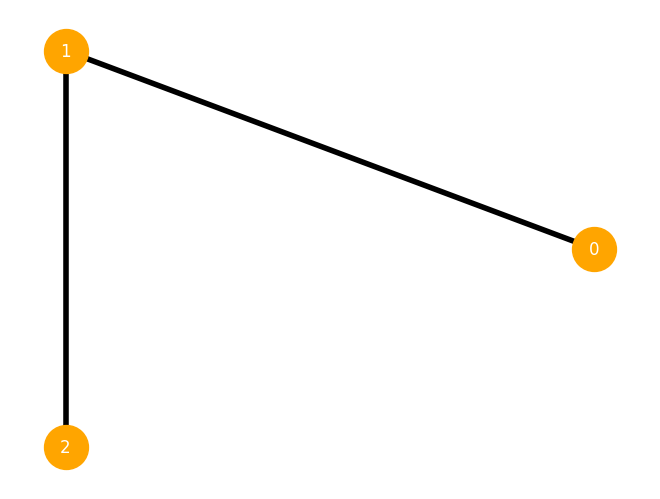

In [14]:
# Defining parameters

n = N
conn_lis = connection_list(E, N)
shots_ = 1024
graph_draw(E)

In [15]:
out = dsp_qaoa(num_iter, n)
out

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


-3.9423828125
-3.9326171875
-3.9921875
-4.03515625
-4.0166015625
-4.0048828125
-4.0
-4.0078125
-4.0537109375
-4.0126953125
-4.064453125
-4.0595703125
-4.0439453125
-4.03515625
-4.03125
-4.03515625
-4.0078125
-3.978515625
-3.88671875
-4.0263671875
-4.0341796875
-4.1337890625
-4.15625
-4.125
-4.07421875
-4.0673828125
-4.0673828125
-4.0634765625
-4.060546875
-4.16015625
-4.2041015625
-3.85546875
-4.3271484375
-3.82421875
-3.85546875
-4.0732421875
-4.1826171875
-3.8369140625
-3.9599609375
-4.076171875
-3.755859375
-3.7880859375
-3.875
-3.8818359375
-3.8408203125
-3.8583984375
-3.947265625
-4.3740234375
-4.015625
-4.3603515625
-3.8720703125
-4.3408203125
-4.5263671875
-4.5849609375
-4.556640625
-4.5546875
-4.4228515625
-4.5322265625
-4.4697265625
-4.53515625
-4.537109375
-4.6435546875
-4.6513671875
-4.6318359375
-4.634765625
-4.65234375
-4.599609375
-4.6416015625
-4.7080078125
-4.619140625
-4.5517578125
-4.6240234375
-4.642578125
-4.6923828125
-4.62109375
-4.6904296875
-4.72265625
-4.711914

     fun: -4.9814453125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 512
  status: 1
 success: True
       x: array([-0.07334794,  3.1871906 ,  3.86822806,  1.82191981,  2.09462349,
        1.78129484,  0.78530473,  2.00908952,  1.78574208,  0.69437399,
        1.12016568,  0.5021669 ,  0.39796698,  1.14829821,  1.95941196,
        0.75740485,  2.77678457,  2.87543079,  2.07984921,  1.61743054,
        1.74285264,  1.77172448,  2.62477814,  1.85657565,  0.40650359,
        0.61702412,  1.9242926 ,  0.98905564,  2.59183528,  2.03005688,
        0.53520836,  2.25862843,  2.43986294,  2.81215466,  2.01297568,
        0.47207804,  2.36562254,  0.41708187,  0.44932105,  0.8123912 ,
        2.27949939,  0.23501739,  0.8929721 ,  0.28000475,  2.0723228 ])

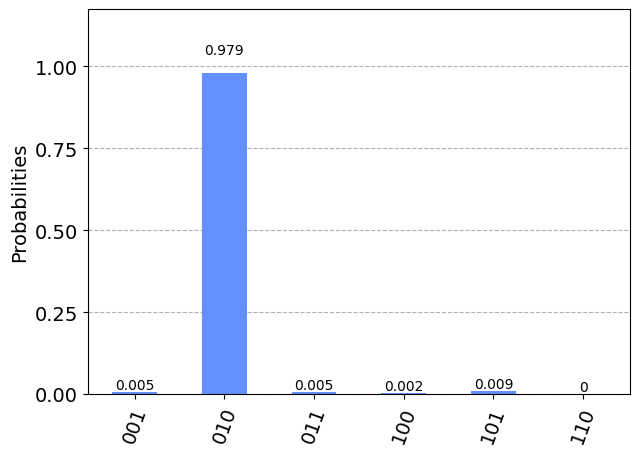

In [16]:
x = [-0.07334794,  3.1871906 ,  3.86822806,  1.82191981,  2.09462349,
        1.78129484,  0.78530473,  2.00908952,  1.78574208,  0.69437399,
        1.12016568,  0.5021669 ,  0.39796698,  1.14829821,  1.95941196,
        0.75740485,  2.77678457,  2.87543079,  2.07984921,  1.61743054,
        1.74285264,  1.77172448,  2.62477814,  1.85657565,  0.40650359,
        0.61702412,  1.9242926 ,  0.98905564,  2.59183528,  2.03005688,
        0.53520836,  2.25862843,  2.43986294,  2.81215466,  2.01297568,
        0.47207804,  2.36562254,  0.41708187,  0.44932105,  0.8123912 ,
        2.27949939,  0.23501739,  0.8929721 ,  0.28000475,  2.0723228 ]
plot_result(x)

In [15]:
# nodes = 3, num_iter = 1

N = 3
E = [(0,1), (1,2)]
num_iter = 1 

n = N
conn_lis = connection_list(E, N)
shots_ = 1024

out = dsp_qaoa(num_iter, n)
out

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


-3.814453125
-3.826171875
-3.923828125
-3.9150390625
-3.7333984375
-3.7421875
-3.73828125
-4.0849609375
-3.591796875
-4.201171875
-4.2060546875
-4.12890625
-4.2021484375
-4.1669921875
-4.19921875
-4.0888671875
-4.2275390625
-4.1337890625
-4.1796875
-4.140625
-4.2294921875
-4.1953125
-4.2568359375
-4.28125
-4.24609375
-4.240234375
-4.251953125
-4.296875
-4.3046875
-4.3095703125
-4.263671875
-4.3369140625
-4.265625
-4.328125
-4.34765625
-4.357421875
-4.3701171875
-4.3818359375
-4.3876953125
-4.40625
-4.4091796875
-4.4140625
-4.4169921875
-4.4140625
-4.431640625
-4.4326171875
-4.451171875
-4.4365234375
-4.443359375
-4.4501953125
-4.4501953125
-4.4501953125
-4.4521484375
-4.4541015625
-4.4560546875
-4.4560546875
-4.4599609375
-4.4619140625
-4.4541015625
-4.4599609375
-4.4619140625
-4.4619140625
-4.4619140625
-4.4560546875
-4.4619140625
-4.458984375
-4.4619140625
-4.4619140625
-4.4619140625
-4.462890625
-4.462890625
-4.462890625
-4.462890625
-4.462890625
-4.4638671875
-4.4638671875
-4.46484

     fun: -4.46484375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 107
  status: 1
 success: True
       x: array([2.61929136, 3.71407312, 0.41089877, 2.49342605, 0.91498058,
       0.98322257, 3.7599312 , 1.72890864, 0.82741585])

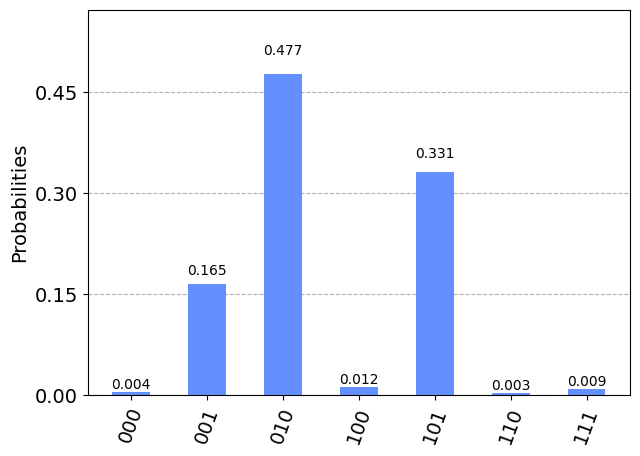

In [16]:
x = [2.61929136, 3.71407312, 0.41089877, 2.49342605, 0.91498058,
       0.98322257, 3.7599312 , 1.72890864, 0.82741585]
plot_result(x)

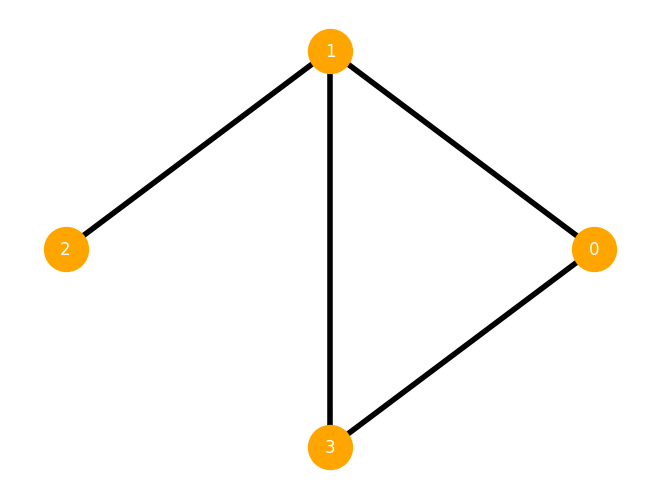

In [17]:
# For a 4 node graph

N = 4
E = [(0,1), (1,2), (0,3), (1,3)]
num_iter = 5

# Defining parameters

n = N
conn_lis = connection_list(E, N)
shots_ = 1024

graph_draw(E)

In [23]:
dsp_qaoa(num_iter, n)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


-5.271484375
-5.359375
-5.3232421875
-5.306640625
-5.3828125
-5.46484375
-5.4189453125
-5.4033203125
-5.529296875
-5.47265625
-5.5478515625
-5.4375
-5.4580078125
-5.6865234375
-5.7392578125
-5.7646484375
-5.740234375
-5.6259765625
-5.7666015625
-5.7236328125
-5.7275390625
-5.7236328125
-5.7666015625
-5.7509765625
-5.7236328125
-5.7197265625
-5.7333984375
-5.7333984375
-5.7197265625
-5.751953125
-5.7919921875
-5.7568359375
-5.7275390625
-5.646484375
-5.6806640625
-5.6982421875
-5.646484375
-5.783203125
-5.7919921875
-5.8681640625
-5.869140625
-5.5634765625
-5.630859375
-5.4365234375
-5.193359375
-5.4541015625
-5.5361328125
-5.353515625
-5.7724609375
-5.677734375
-5.5283203125
-5.443359375
-5.76171875
-5.5849609375
-5.2705078125
-5.7265625
-5.2412109375
-5.349609375
-5.7646484375
-5.666015625
-5.375
-5.384765625
-5.8974609375
-5.3466796875
-5.8984375
-5.36328125
-5.8681640625
-5.8759765625
-5.908203125
-5.9072265625
-5.908203125
-5.8779296875
-5.9052734375
-5.9287109375
-5.884765625
-5.9

-6.798828125
-6.798828125
-6.798828125
-6.798828125
-6.798828125
-6.798828125
-6.798828125
-6.798828125
-6.798828125
-6.798828125
-6.798828125
-6.798828125
-6.798828125
-6.798828125
-6.798828125
-6.798828125
-6.798828125
-6.798828125
-6.798828125
-6.798828125
-6.798828125
-6.798828125
-6.798828125
-6.798828125
-6.798828125
-6.798828125
-6.798828125
-6.798828125
-6.798828125
-6.798828125
-6.798828125
-6.798828125
-6.798828125
-6.798828125
-6.798828125
-6.798828125
-6.798828125


     fun: -6.798828125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 667
  status: 1
 success: True
       x: array([ 1.44394421,  1.62786301,  0.82302388,  4.74222458,  3.44214703,
        1.34524791,  2.29361826,  2.30663902,  2.42224601,  2.41014115,
        1.30081062,  0.53958464,  3.6360655 ,  2.85099454,  2.91961457,
        1.89465554,  1.95385549,  4.23877178,  3.50174508, -0.62893955,
        1.88435855,  1.85453195,  2.8767516 ,  1.34650259,  0.17190452,
        1.04782402,  2.28467972,  1.21683212,  2.87790796,  3.19505949,
        1.22287312,  2.08064739,  0.66820546,  3.17958412,  1.73125397,
        0.83698953,  0.94069811,  1.16413329,  3.71780917,  3.36590533,
        2.52577933,  2.59956045,  0.20933749, -0.10292422,  1.23773334,
        2.32839775,  0.82119857,  2.54760006,  1.67085615,  1.80950137,
        1.01453882,  0.5380001 ,  1.56367743,  1.13830893,  1.28207876,
        1.5816744 ,  1.27722696,  1.20232524,  0.81764763,  2.19573118

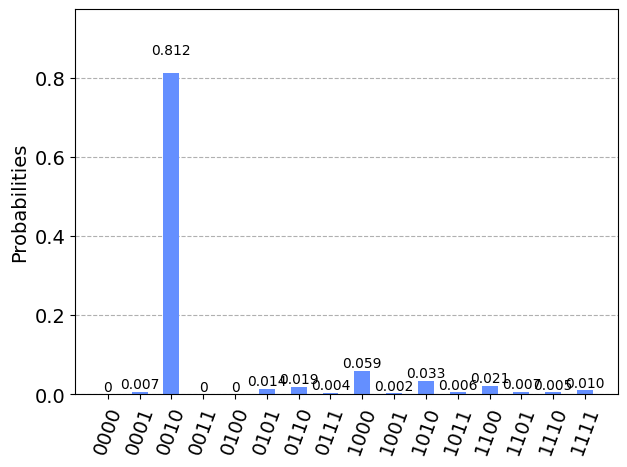

In [18]:
x2 = [ 1.44394421,  1.62786301,  0.82302388,  4.74222458,  3.44214703,
        1.34524791,  2.29361826,  2.30663902,  2.42224601,  2.41014115,
        1.30081062,  0.53958464,  3.6360655 ,  2.85099454,  2.91961457,
        1.89465554,  1.95385549,  4.23877178,  3.50174508, -0.62893955,
        1.88435855,  1.85453195,  2.8767516 ,  1.34650259,  0.17190452,
        1.04782402,  2.28467972,  1.21683212,  2.87790796,  3.19505949,
        1.22287312,  2.08064739,  0.66820546,  3.17958412,  1.73125397,
        0.83698953,  0.94069811,  1.16413329,  3.71780917,  3.36590533,
        2.52577933,  2.59956045,  0.20933749, -0.10292422,  1.23773334,
        2.32839775,  0.82119857,  2.54760006,  1.67085615,  1.80950137,
        1.01453882,  0.5380001 ,  1.56367743,  1.13830893,  1.28207876,
        1.5816744 ,  1.27722696,  1.20232524,  0.81764763,  2.19573118]

plot_result(x2)

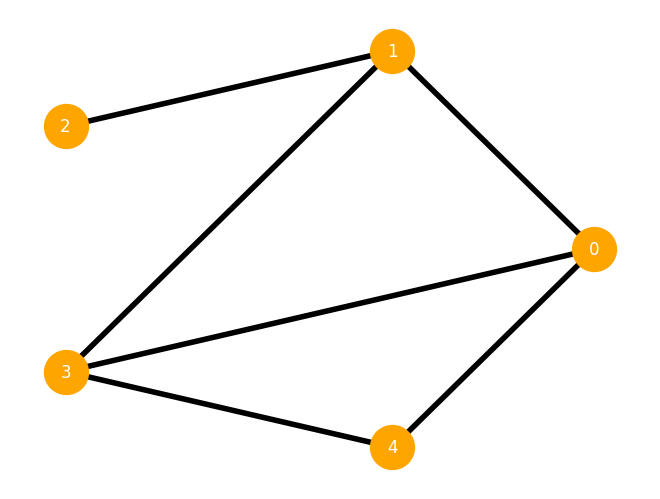

In [19]:
# For a 5 node graph

N = 5
E = [(0,1), (1,2), (0,3), (1,3), (3,4), (0,4)]
num_iter = 5

# Defining parameters

n = N
conn_lis = connection_list(E, N)
shots_ = 1024

graph_draw(E)

In [26]:
dsp_qaoa(num_iter, n)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


-6.5556640625
-6.5751953125
-6.5126953125
-6.44140625
-6.619140625
-6.6611328125
-6.6806640625
-6.6953125
-6.59375
-6.703125
-6.673828125
-6.6943359375
-6.7578125
-6.64453125
-6.7587890625
-6.814453125
-6.78125
-6.7587890625
-6.767578125
-6.791015625
-6.861328125
-6.8876953125
-6.837890625
-6.8544921875
-6.89453125
-6.8984375
-6.81640625
-6.873046875
-6.931640625
-6.9140625
-7.0224609375
-6.95703125
-7.001953125
-7.0458984375
-7.0322265625
-7.0927734375
-7.083984375
-7.0390625
-7.0859375
-7.083984375
-7.0869140625
-6.9970703125
-7.076171875
-7.12890625
-6.958984375
-6.9794921875
-7.04296875
-7.08984375
-7.08984375
-7.04296875
-7.1201171875
-7.00390625
-7.0068359375
-7.0966796875
-7.0830078125
-6.93359375
-7.126953125
-7.1142578125
-6.986328125
-6.8974609375
-7.0732421875
-7.037109375
-7.04296875
-7.1005859375
-6.7939453125
-7.078125
-7.0947265625
-6.974609375
-7.029296875
-6.818359375
-7.1787109375
-7.2666015625
-7.0068359375
-7.193359375
-6.8203125
-7.1796875
-6.9189453125
-7.27246093

-7.828125
-7.8291015625
-7.828125
-7.8291015625
-7.8291015625
-7.828125
-7.828125
-7.8291015625
-7.828125
-7.828125
-7.8291015625
-7.8271484375
-7.828125
-7.828125
-7.8291015625
-7.8291015625
-7.8291015625
-7.8291015625
-7.828125
-7.828125
-7.8291015625
-7.8291015625
-7.828125
-7.8291015625
-7.8291015625
-7.828125
-7.8291015625
-7.8291015625
-7.828125
-7.8291015625
-7.8291015625
-7.8291015625
-7.8291015625
-7.8291015625
-7.828125
-7.8291015625
-7.828125
-7.8291015625
-7.8291015625
-7.8291015625
-7.828125
-7.828125
-7.828125
-7.8291015625
-7.8291015625
-7.8291015625
-7.8291015625
-7.828125
-7.8291015625
-7.8291015625
-7.8291015625
-7.828125
-7.828125
-7.8291015625
-7.8291015625
-7.8291015625
-7.8291015625
-7.8291015625
-7.8291015625
-7.8291015625
-7.8291015625
-7.8291015625
-7.8291015625
-7.8291015625
-7.8291015625
-7.8291015625
-7.828125
-7.8291015625
-7.8291015625
-7.8291015625
-7.8291015625
-7.8291015625
-7.8291015625
-7.8291015625
-7.8291015625
-7.8291015625
-7.8291015625
-7.828125


     fun: -7.8291015625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 781
  status: 1
 success: True
       x: array([2.27788651, 2.69048417, 0.19888601, 1.81741054, 2.41673675,
       1.37816524, 2.07010448, 2.28931712, 2.90059309, 1.76009718,
       1.47860466, 3.38441172, 1.52819592, 1.27273983, 2.13641047,
       3.25299775, 0.54929626, 1.4291907 , 2.58313423, 1.59441349,
       2.1905828 , 1.81211544, 2.8740898 , 3.83913089, 2.43593515,
       1.15613443, 2.70139498, 2.13503796, 2.49754755, 1.763233  ,
       0.4605258 , 2.51196366, 2.53157026, 2.21745215, 2.99038916,
       2.0347374 , 2.77727731, 0.68972693, 1.47241493, 0.4509166 ,
       2.29331442, 2.15804041, 3.61975706, 2.16735832, 1.73190543,
       2.94097753, 2.17644612, 0.09813071, 2.90571428, 2.40802515,
       0.36130181, 2.38758007, 0.65433806, 2.19793052, 2.23997095,
       1.93412786, 2.24674741, 2.75976043, 3.14557101, 1.53007254,
       2.19234291, 1.78568154, 0.84482057, 0.40655564, 2.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


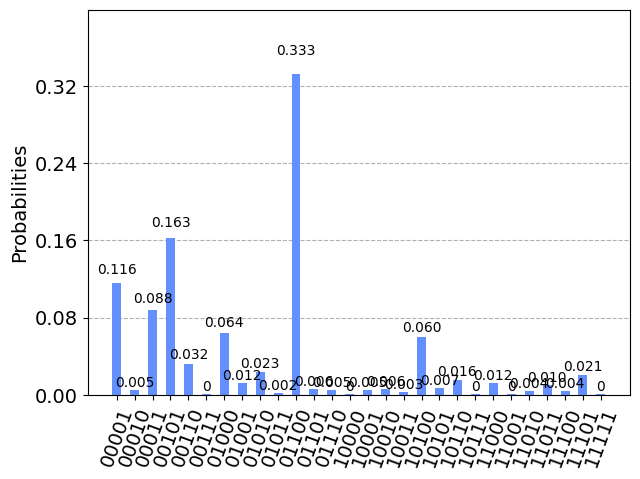

In [20]:
x3 = [2.27788651, 2.69048417, 0.19888601, 1.81741054, 2.41673675,
       1.37816524, 2.07010448, 2.28931712, 2.90059309, 1.76009718,
       1.47860466, 3.38441172, 1.52819592, 1.27273983, 2.13641047,
       3.25299775, 0.54929626, 1.4291907 , 2.58313423, 1.59441349,
       2.1905828 , 1.81211544, 2.8740898 , 3.83913089, 2.43593515,
       1.15613443, 2.70139498, 2.13503796, 2.49754755, 1.763233  ,
       0.4605258 , 2.51196366, 2.53157026, 2.21745215, 2.99038916,
       2.0347374 , 2.77727731, 0.68972693, 1.47241493, 0.4509166 ,
       2.29331442, 2.15804041, 3.61975706, 2.16735832, 1.73190543,
       2.94097753, 2.17644612, 0.09813071, 2.90571428, 2.40802515,
       0.36130181, 2.38758007, 0.65433806, 2.19793052, 2.23997095,
       1.93412786, 2.24674741, 2.75976043, 3.14557101, 1.53007254,
       2.19234291, 1.78568154, 0.84482057, 0.40655564, 2.51647799,
       2.25428269, 2.78705371, 2.51769691, 0.89210642, 3.86566507,
       3.58142173, 0.73772566, 2.90462325, 0.99581949, 1.60222313]

plot_result(x3)

## Running on Noisy simulator

In [21]:
# Cost function_noisy

def cost_fun_noise(parameters):
    
    gamma1 = parameters[0:n*num_iter]
    gamma2 = parameters[n*num_iter : 2*n*num_iter]
    beta = parameters[2*n*num_iter:]
    
    dsp_circuit = QuantumCircuit(n+1, n)
    
    dsp_circuit.h(range(n))
    dsp_circuit.x(n)
    
        
    for iz in range(num_iter):
        
        D_k_clause(dsp_circuit, n, gamma1[n*(iz): n*(iz+1)])
        T_k_clause(dsp_circuit, conn_lis, n, gamma2[n*(iz): n*(iz+1)])
        mixer(dsp_circuit, n, beta[n*(iz): n*(iz+1)])
        
    dsp_circuit.measure(range(n), range(n))


    backend = FakeNairobi()
    qc_res = transpile(dsp_circuit, backend=backend, optimization_level=3)
    counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
    
    shots = shots_
    
    cost = 0
    
    for key in counts.keys():
        cost -= counts[key]*(T(key) + D(key))/shots
        
    print(cost)
    return cost

In [22]:
def dsp_qaoa_noise(num_iter, n):
    
    out = minimize(cost_fun_noise, x0=[float(random.randint(0,3000))/1000 for i in range(3*n*num_iter)], 
                   method = "COBYLA")
    return out

In [41]:
# Plots histogram for given parameters on noisy simulation

def plot_result_noise (x):
    gamma1 = x[0:n*num_iter]
    gamma2 = x[n*num_iter : 2*n*num_iter]
    beta = x[2*n*num_iter:]

    dsp_circ = QuantumCircuit(n+1, n)

    dsp_circ.h(range(n))
    dsp_circ.x(n)
    for iz in range(num_iter):
        D_k_clause(dsp_circ, n, gamma1[n*(iz): n*(iz+1)])
        T_k_clause(dsp_circ, conn_lis, n, gamma2[n*(iz): n*(iz+1)])
        mixer(dsp_circ, n, beta[n*(iz): n*(iz+1)])


    dsp_circ.measure(range(n), range(n))

    job = execute(dsp_circ, backend=FakeNairobi(), shots=1024)
    results = job.result()
    counts = results.get_counts()
    
    return  plot_histogram(counts)

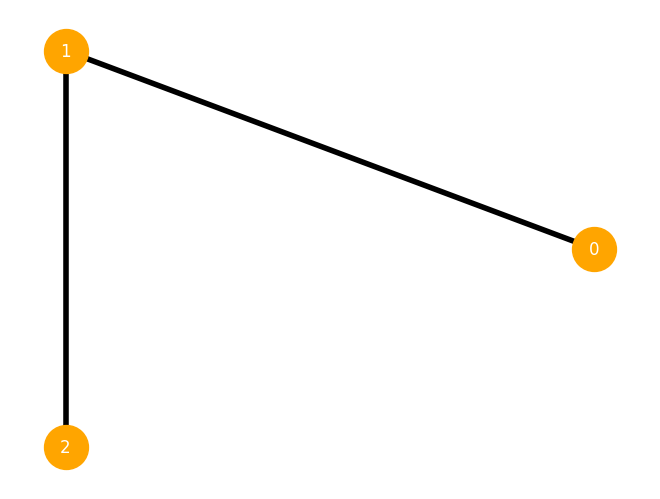

In [17]:
# Running the algorithm for 3 nodes on complete noisy simulator
# Nodes = 3
# Num_iter = 2

N = 3
E = [(0,1), (1,2)]
num_iter = 2

n = N
conn_lis = connection_list(E, N)
shots_ = 1024

graph_draw(E)

In [18]:
dsp_qaoa_noise(num_iter, n)

-3.861328125
-3.8818359375
-3.8740234375
-3.85546875
-3.86328125
-3.873046875
-3.8525390625
-3.8388671875
-3.845703125
-3.869140625
-3.8896484375
-3.869140625
-3.87890625
-3.91796875
-3.9287109375
-3.92578125
-3.912109375
-3.91015625
-3.8740234375
-3.896484375
-3.912109375
-3.9013671875
-3.8935546875
-3.884765625
-3.88671875
-3.8935546875
-3.8984375
-3.921875
-3.8974609375
-3.8955078125
-3.908203125
-3.9072265625
-3.888671875
-3.90625
-3.935546875
-3.8916015625
-3.892578125
-3.9267578125
-3.904296875
-3.9326171875
-3.890625
-3.9365234375
-3.8955078125
-3.8857421875
-3.8857421875
-3.90625
-3.8955078125
-3.884765625
-3.888671875
-3.90234375
-3.8994140625
-3.888671875
-3.8955078125
-3.8818359375
-3.9423828125
-3.9453125
-3.9169921875
-3.916015625
-3.90625
-3.89453125
-3.900390625
-3.8974609375
-3.896484375
-3.9111328125
-3.953125
-3.8974609375
-3.9560546875
-3.8955078125
-3.8916015625
-3.95703125
-3.90625
-3.921875
-3.986328125
-3.9033203125
-3.923828125
-3.90234375
-3.8984375
-3.90039062

     fun: -3.9208984375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 165
  status: 1
 success: True
       x: array([ 3.55011461e+00,  2.69993424e-01,  2.46840670e+00,  2.76521805e+00,
        5.68529959e-01,  1.58582229e+00,  2.43753223e-01, -2.78447783e-03,
        7.52031701e-01,  3.52958714e+00,  1.43565013e+00,  2.48674761e+00,
        2.34860839e+00,  2.39584423e+00,  8.20586238e-01,  2.89442030e+00,
        2.18958717e+00,  2.76207206e+00])

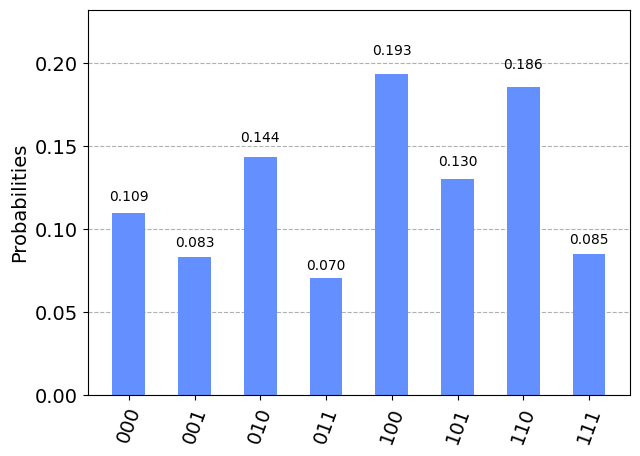

In [20]:
x = [ 3.55011461e+00,  2.69993424e-01,  2.46840670e+00,  2.76521805e+00,
        5.68529959e-01,  1.58582229e+00,  2.43753223e-01, -2.78447783e-03,
        7.52031701e-01,  3.52958714e+00,  1.43565013e+00,  2.48674761e+00,
        2.34860839e+00,  2.39584423e+00,  8.20586238e-01,  2.89442030e+00,
        2.18958717e+00,  2.76207206e+00]

plot_result_noise(x)

In [21]:
# Nodes = 3
# Num_iter = 3

N = 3
E = [(0,1), (1,2)]
num_iter = 3

n = N
conn_lis = connection_list(E, N)
shots_ = 1024

dsp_qaoa_noise(num_iter, n)

-3.8837890625
-3.890625
-3.88671875
-3.884765625
-3.888671875
-3.888671875
-3.8916015625
-3.8955078125
-3.9111328125
-3.875
-3.8935546875
-3.8916015625
-3.890625
-3.9248046875
-3.8779296875
-3.8916015625
-3.8974609375
-3.8935546875
-3.9130859375
-3.880859375
-3.884765625
-3.8837890625
-3.892578125
-3.88671875
-3.8818359375
-3.8984375
-3.87890625
-3.8916015625
-3.85546875
-3.8935546875
-3.8828125
-3.892578125
-3.859375
-3.8916015625
-3.8818359375
-3.890625
-3.8603515625
-3.8935546875
-3.86328125
-3.8828125
-3.8935546875
-3.8984375
-3.892578125
-3.9052734375
-3.923828125
-3.8935546875
-3.8935546875
-3.8935546875
-3.8935546875
-3.8779296875
-3.8984375
-3.8916015625
-3.8935546875
-3.8818359375
-3.892578125
-3.9267578125
-3.91015625
-3.8935546875
-3.8876953125
-3.890625
-3.921875
-3.8828125
-3.8818359375
-3.8876953125
-3.8935546875
-3.9091796875
-3.896484375
-3.89453125
-3.892578125
-3.8818359375
-3.91015625
-3.8720703125
-3.880859375
-3.888671875
-3.87890625
-3.8896484375
-3.912109375
-3.8

     fun: -3.892578125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 235
  status: 1
 success: True
       x: array([2.04261749, 1.62192848, 2.06488986, 2.39556744, 1.82087731,
       2.43465028, 1.87998027, 3.06527749, 2.1278039 , 1.19719573,
       1.92619856, 0.03455909, 1.99420338, 1.1017646 , 1.73878397,
       2.21506532, 3.0374185 , 1.46675978, 2.63670944, 2.81894854,
       2.49982911, 0.83228156, 2.88565396, 2.45046908, 2.42428121,
       2.63386593, 0.72648011])

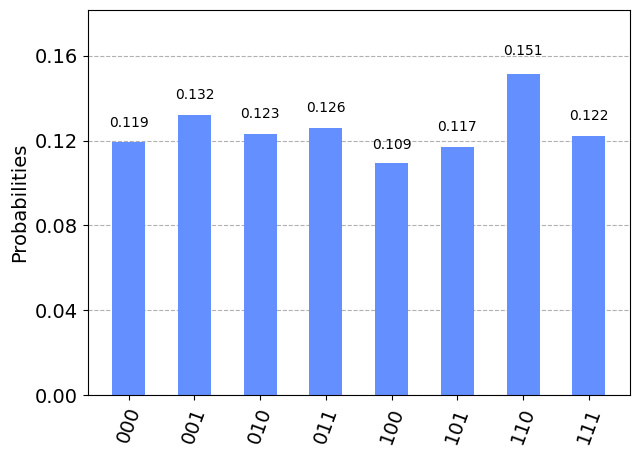

In [22]:
x = [2.04261749, 1.62192848, 2.06488986, 2.39556744, 1.82087731,
       2.43465028, 1.87998027, 3.06527749, 2.1278039 , 1.19719573,
       1.92619856, 0.03455909, 1.99420338, 1.1017646 , 1.73878397,
       2.21506532, 3.0374185 , 1.46675978, 2.63670944, 2.81894854,
       2.49982911, 0.83228156, 2.88565396, 2.45046908, 2.42428121,
       2.63386593, 0.72648011]

plot_result_noise(x)

In [23]:
# nodes = 3
# num_iter = 1

N = 3
E = [(0,1), (1,2)]
num_iter = 1

n = N
conn_lis = connection_list(E, N)
shots_ = 1024

dsp_qaoa_noise(num_iter, n)

-3.8662109375
-3.8369140625
-3.8603515625
-3.8134765625
-3.865234375
-3.84375
-3.828125
-3.8759765625
-3.7861328125
-3.943359375
-3.88671875
-3.958984375
-4.005859375
-3.95703125
-3.96875
-3.9697265625
-3.9658203125
-3.9873046875
-3.958984375
-3.9326171875
-3.9873046875
-4.015625
-3.9521484375
-3.9609375
-3.966796875
-3.9736328125
-3.97265625
-3.9599609375
-3.9462890625
-3.9873046875
-3.958984375
-3.94921875
-3.9697265625
-3.9833984375
-3.951171875
-3.951171875
-3.9541015625
-3.97265625
-3.951171875
-3.9638671875
-3.9609375
-3.98046875
-3.953125
-3.9501953125
-3.98046875
-3.958984375
-3.98828125
-3.953125
-3.9580078125
-3.958984375
-3.9541015625
-3.9541015625
-3.951171875
-3.984375
-3.97265625
-3.9541015625
-3.970703125
-3.96484375
-3.98046875
-3.9619140625
-3.970703125
-3.966796875
-3.9814453125
-3.9853515625
-3.953125
-3.97265625
-3.958984375
-3.9873046875
-3.955078125
-4.01171875
-3.9521484375
-3.955078125
-3.984375
-3.9619140625
-3.951171875
-3.951171875
-3.958984375
-3.9599609375


     fun: -3.966796875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 84
  status: 1
 success: True
       x: array([0.77453039, 0.9683857 , 1.69981985, 1.08284693, 1.72477178,
       1.14759206, 1.02187881, 2.62936964, 2.48426919])

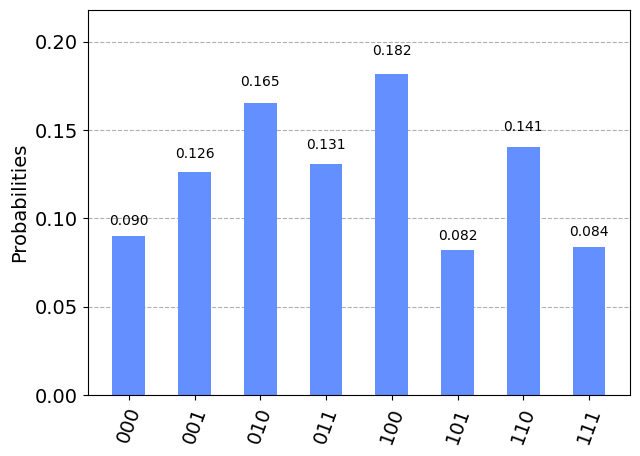

In [24]:
x = [0.77453039, 0.9683857 , 1.69981985, 1.08284693, 1.72477178,
       1.14759206, 1.02187881, 2.62936964, 2.48426919]


plot_result_noise(x)

In [24]:
""" Running the cost function on non-noisy simulator and final circuit on noisy simulator"""

# nodes = 3
# num_iter = 5

N = 3
E = [(0,1), (1,2)]
num_iter = 5

n = N
conn_lis = connection_list(E, N)
shots_ = 1024

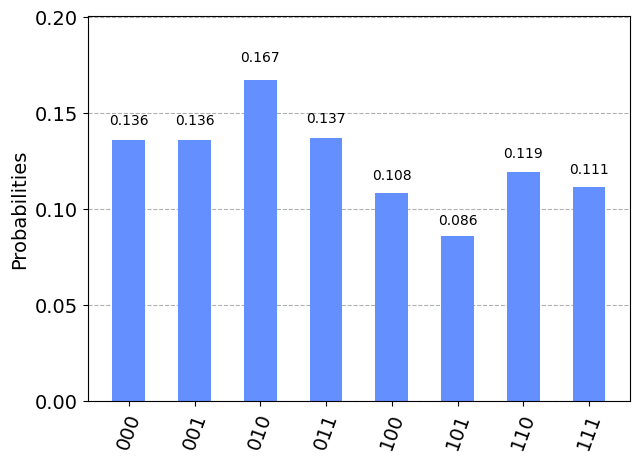

In [26]:
x1 = [-0.07334794,  3.1871906 ,  3.86822806,  1.82191981,  2.09462349,
        1.78129484,  0.78530473,  2.00908952,  1.78574208,  0.69437399,
        1.12016568,  0.5021669 ,  0.39796698,  1.14829821,  1.95941196,
        0.75740485,  2.77678457,  2.87543079,  2.07984921,  1.61743054,
        1.74285264,  1.77172448,  2.62477814,  1.85657565,  0.40650359,
        0.61702412,  1.9242926 ,  0.98905564,  2.59183528,  2.03005688,
        0.53520836,  2.25862843,  2.43986294,  2.81215466,  2.01297568,
        0.47207804,  2.36562254,  0.41708187,  0.44932105,  0.8123912 ,
        2.27949939,  0.23501739,  0.8929721 ,  0.28000475,  2.0723228 ]


plot_result_noise(x1)


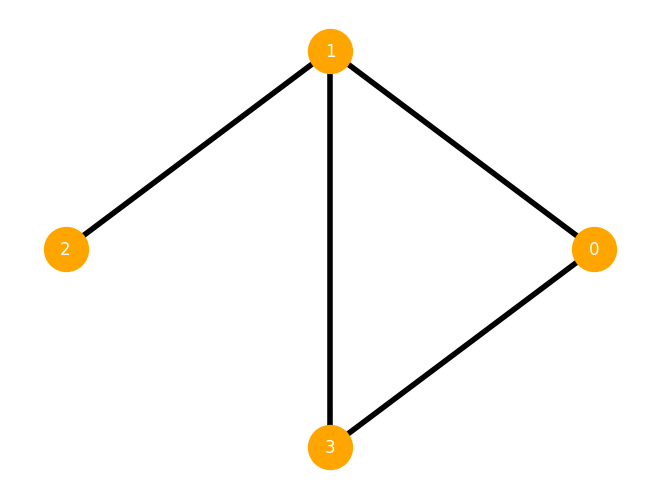

In [34]:
""" Running the cost function on non-noisy simulator and final circuit on noisy simulator"""

# nodes = 4
# num_iter = 5

N = 4
E = [(0,1), (1,2), (0,3), (1,3)]
num_iter = 5

# Defining parameters

n = N
conn_lis = connection_list(E, N)
shots_ = 1024

graph_draw(E)

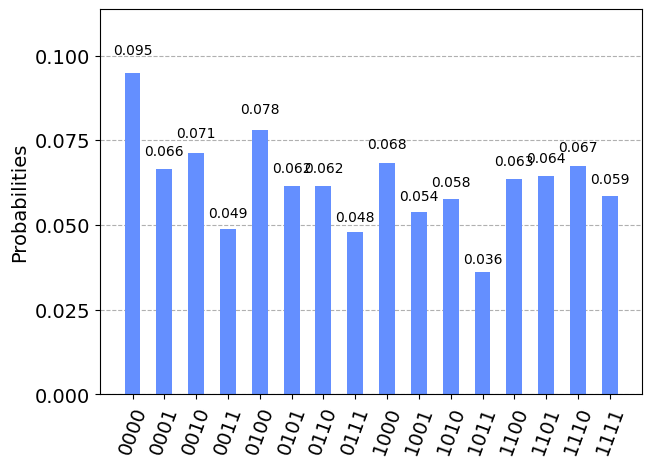

In [35]:
plot_result_noise(x2)

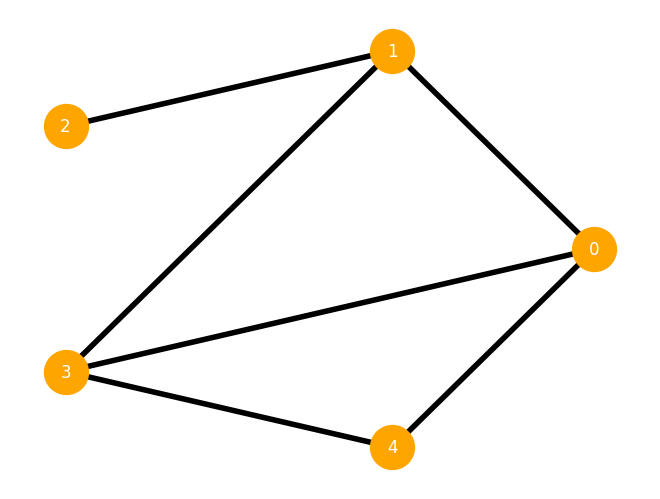

In [32]:
""" Running the cost function on non-noisy simulator and final circuit on noisy simulator"""

# nodes = 5
# num_iter = 5

N = 5
E = [(0,1), (1,2), (0,3), (1,3), (3,4), (0,4)]
num_iter = 5

# Defining parameters

n = N
conn_lis = connection_list(E, N)
shots_ = 1024

graph_draw(E)

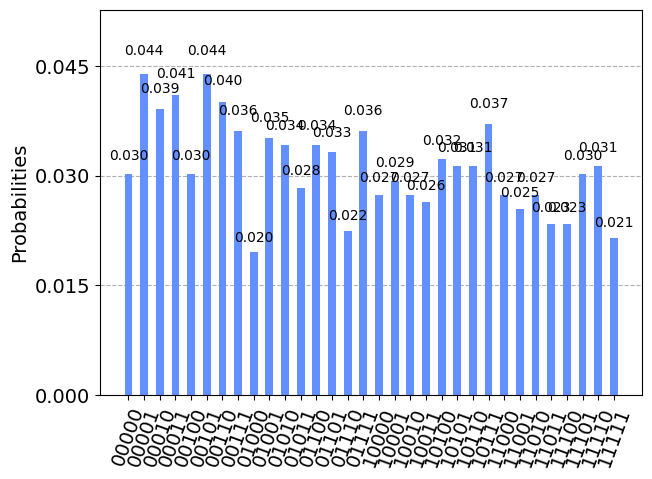

In [33]:
plot_result_noise(x3)

## Running on IBM Quantum computer

In [36]:
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_oslo') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [43]:
from qiskit.tools.monitor import job_monitor

In [37]:
backend_ibm = provider.get_backend('ibm_oslo')
backend_ibm

<IBMQBackend('ibm_oslo') from IBMQ(hub='ibm-q', group='open', project='main')>

In [44]:
# Plots histogram for given parameters on IBM quantum computer

def plot_result_noise_ibm (x):
    gamma1 = x[0:n*num_iter]
    gamma2 = x[n*num_iter : 2*n*num_iter]
    beta = x[2*n*num_iter:]

    dsp_circ = QuantumCircuit(n+1, n)

    dsp_circ.h(range(n))
    dsp_circ.x(n)
    for iz in range(num_iter):
        D_k_clause(dsp_circ, n, gamma1[n*(iz): n*(iz+1)])
        T_k_clause(dsp_circ, conn_lis, n, gamma2[n*(iz): n*(iz+1)])
        mixer(dsp_circ, n, beta[n*(iz): n*(iz+1)])


    dsp_circ.measure(range(n), range(n))
    
    backend = backend_ibm
    dsp_trans = transpile(dsp_circ, backend=backend_ibm, optimization_level=3)
    job = backend.run(dsp_trans,  shots=1024)
    print(job.job_id)
    job_monitor(job)
    results = job.result()
    
    counts = results.get_counts()
    
    return  plot_histogram(counts)

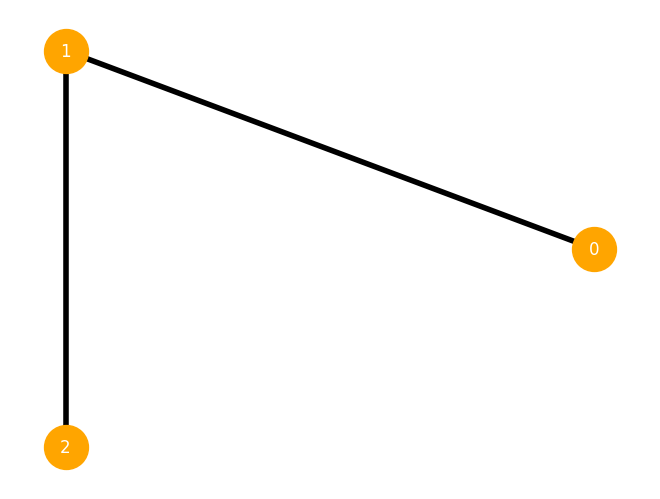

In [45]:
""" Running the cost function on non-noisy simulator and final circuit on IBM quantum computer"""

# nodes = 3
# num_iter = 5

N = 3
E = [(0,1), (1,2)]
num_iter = 5

n = N
conn_lis = connection_list(E, N)
shots_ = 1024

graph_draw(E)

<bound method IBMQJob.job_id of <qiskit.providers.ibmq.job.ibmqjob.IBMQJob object at 0x145518a00>>
Job Status: job has successfully run


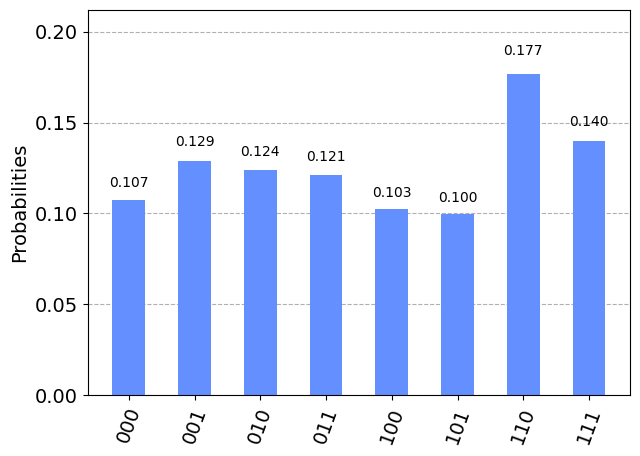

In [46]:
plot_result_noise_ibm(x1)

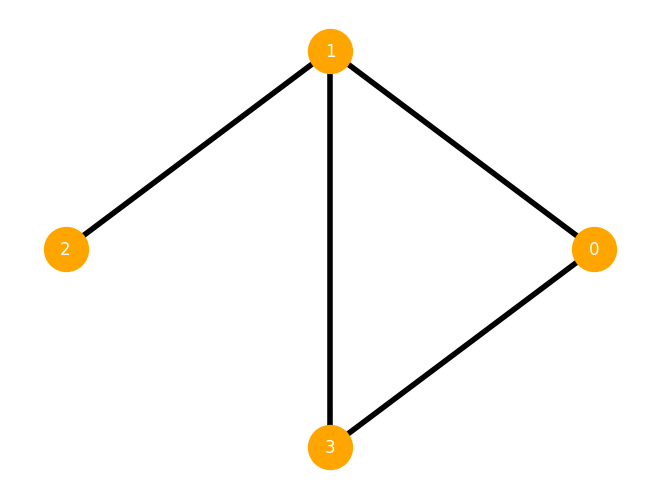

In [47]:
""" Running the cost function on non-noisy simulator and final circuit on IBM quantum computer"""

# nodes = 4
# num_iter = 5

N = 4
E = [(0,1), (1,2), (0,3), (1,3)]
num_iter = 5

# Defining parameters

n = N
conn_lis = connection_list(E, N)
shots_ = 1024

graph_draw(E)

<bound method IBMQJob.job_id of <qiskit.providers.ibmq.job.ibmqjob.IBMQJob object at 0x143f02380>>
Job Status: job has successfully run


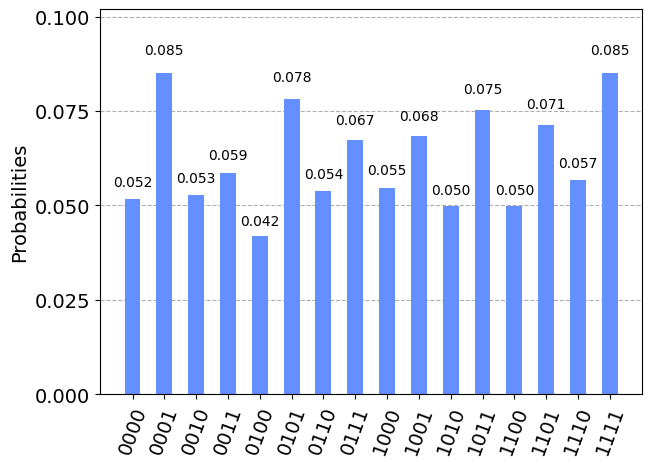

In [48]:
plot_result_noise_ibm(x2)

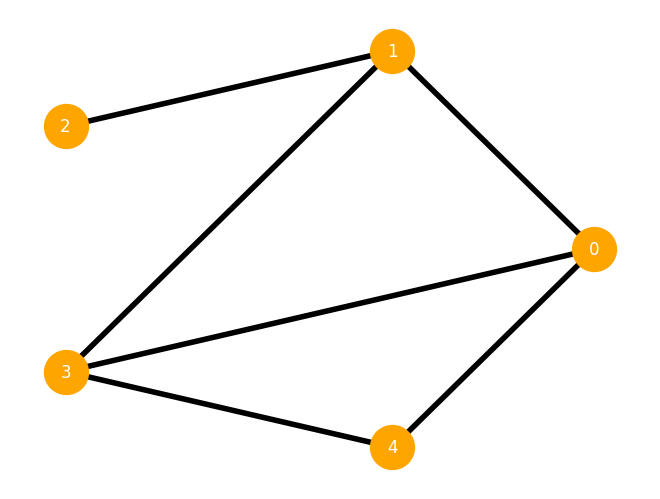

In [49]:
""" Running the cost function on non-noisy simulator and final circuit on IBM quantum computer"""

# nodes = 5
# num_iter = 5

N = 5
E = [(0,1), (1,2), (0,3), (1,3), (3,4), (0,4)]
num_iter = 5

# Defining parameters

n = N
conn_lis = connection_list(E, N)
shots_ = 1024

graph_draw(E)

<bound method IBMQJob.job_id of <qiskit.providers.ibmq.job.ibmqjob.IBMQJob object at 0x144cf88e0>>
Job Status: job has successfully run


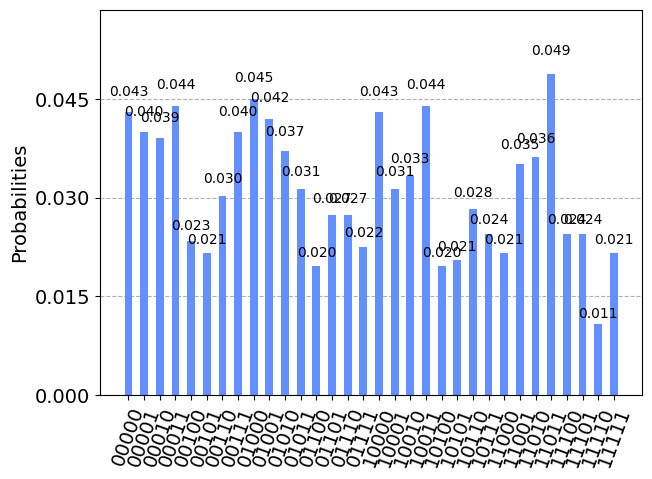

In [50]:
plot_result_noise_ibm(x3)